Assignment 4

Brendon Bottle

COMP 4432

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from prettytable import PrettyTable
import pickle
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Create random_state varaible for use throughout code

rs = 7284

# Part 1 - Data Exploration

In [3]:
# Load dataset

url = 'https://raw.githubusercontent.com/arjayit/cs4432_data/master/bike_share_hour.csv'

bike_df = pd.read_csv(url)

## Categorical features

Looking at the README file and using the number of unique instances in each column as a rough guide, we can see that the following columns can be treated as categorical:

Season (1: Spring, 2: Summer, 3: Fall, 4: Winter) 
Holiday (0: No, 1: Yes) 
Workingday (0: No (either weekend or holiday), 1: Yes,)
Weathersit (1: Clear, 2: Mist/Cloudy/etc, 3: Light Snow/Rain/etc, 4: Heavy Rain/Ice/etc.)
yr (0: 2011, 1: 2012)

There are also 3 cyclical, ordinal features that could potentially be treated as categorical or as continuous:

mnth (1:12)
hr (0:23)
weekday (0:6)

To determine the best way to treat the ordinal varaibles I will run the linear model with them treated as numberical and as categorical and determine which model performs better

In [4]:
# Check number of unique values in each feature
print(bike_df.nunique())

# Look at unique values in features that are categorical
print('\nUnique values for categorical columns:\n')
for column in bike_df:
    if len(bike_df[column].unique()) < 5:
        print(column, ': ', bike_df[column].unique())

instant       17379
dteday          731
season            4
yr                2
mnth             12
hr               24
holiday           2
weekday           7
workingday        2
weathersit        4
temp             50
atemp            65
hum              89
windspeed        30
casual          322
registered      776
cnt             869
dtype: int64

Unique values for categorical columns:

season :  [1 2 3 4]
yr :  [0 1]
holiday :  [0 1]
workingday :  [0 1]
weathersit :  [1 2 3 4]


In [5]:
categorical = ['season', 'holiday', 'workingday', 'weathersit', 'yr']
ordinal = ['mnth', 'hr', 'weekday']

In [6]:
# Update first 5 categorical columns
bike_df[categorical] = bike_df[categorical].astype('category')

# Create second data frame to convert ordinal features to category
bike_df_ord = bike_df.copy()

bike_df_ord[ordinal] = bike_df[ordinal].astype('category')

print(bike_df.dtypes)
print(bike_df_ord.dtypes)

instant          int64
dteday          object
season        category
yr            category
mnth             int64
hr               int64
holiday       category
weekday          int64
workingday    category
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
dtype: object
instant          int64
dteday          object
season        category
yr            category
mnth          category
hr            category
holiday       category
weekday       category
workingday    category
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
dtype: object


## Non-null values

Looking at the info printout, it appears that there are no null values present, but as a double check we'll use the isnull/sum methods.

In [7]:
bike_df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## Descriptive statistics

Looking at the descriptive statistics temp, atemp, hum, and windspeed all seem to have been standardized to range between 0 and 1. Looking at cnt, it appears that there were no days/times that no bikes were rented.

In [8]:
# Look at descriptive statistics for all columns that do not have a dtype of 'category'

bike_df.select_dtypes(exclude='category').describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000
hum,17379.0,0.627229,0.192930,0.00,0.4800,0.6300,0.7800,1.0000
windspeed,17379.0,0.190098,0.122340,0.00,0.1045,0.1940,0.2537,0.8507
casual,17379.0,35.676218,49.305030,0.00,4.0000,17.0000,48.0000,367.0000
registered,17379.0,153.786869,151.357286,0.00,34.0000,115.0000,220.0000,886.0000


## Map Seasons to Months

While in the README file the seasons are coded to {1: Spring, 2: Summer, 3: Fall, 4: Winter}, if we map months to seasons it becomes that this is an error

Using the astronomical start measure of seasons, winter starts on December 21st, Spring starts on March 21st, Summer starts on June 21st, and Fall starts on September 23rd. Matching this with the months (for example, December (12) occuring in both 1 and 4), the correct matching must be {1: Winter, 2: Spring, 3: Summer, 4: Fall}

This matching also makes much more intuitve sense when looking at the following plots. 

In [9]:
for s in range(1,5):
    temp_df = bike_df['mnth'][bike_df['season'] == s]
    print(f'The months in {s} are: ', temp_df.unique())

The months in 1 are:  [ 1  2  3 12]
The months in 2 are:  [3 4 5 6]
The months in 3 are:  [6 7 8 9]
The months in 4 are:  [ 9 10 11 12]


## Plots of Data

### Season vs Count

Unsurprisingly, summer sees the highest number of bike rentals while winter sees the fewest. While we will look at this in further rplots, it would make intuitive sense that this is related to weather since you should see better biking weather in summer

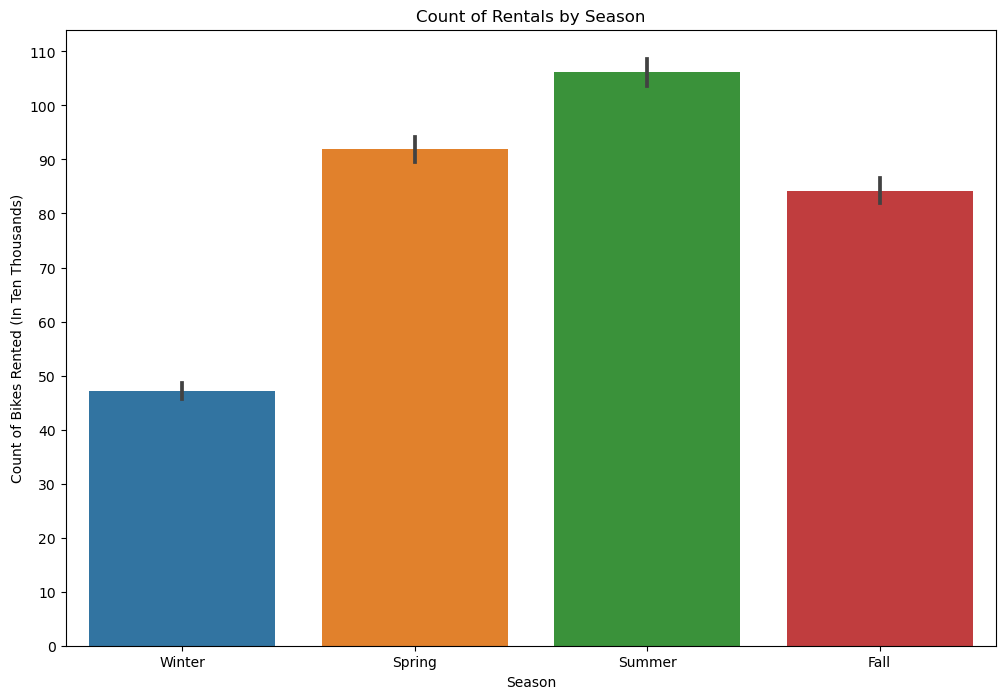

In [10]:
fig1, ax1 = plt.subplots(figsize= (12, 8))
sns.barplot(data = bike_df, x='season', y='cnt', estimator=lambda x: x.sum()/10000, ax= ax1)
plt.xticks([0,1,2,3], ['Winter', 'Spring', 'Summer', 'Fall'])
plt.yticks(range(0, 111, 10))
plt.ylabel('Count of Bikes Rented (In Ten Thousands)')
plt.xlabel('Season')
plt.title('Count of Rentals by Season')
plt.show()

### Working Day vs Count

Bike rentals appear to be significantly higher on work days, this would indicate the majority of renters are using the bikes for commuting purposes. We can double check that assumption by looking at the hours that individuals rent bikes, which we will do later in this assignment.

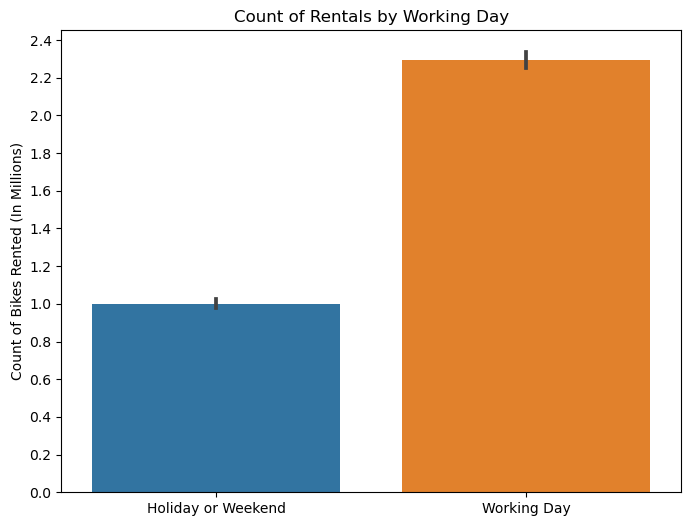

In [11]:
f2, ax2 = plt.subplots(figsize= (8, 6))
sns.barplot(data = bike_df, y='cnt', x='workingday', estimator= lambda x: x.sum()/1000000, ax=ax2)
plt.xticks([0,1], ['Holiday or Weekend', 'Working Day'])
plt.yticks(np.arange(0, 2.5, 0.2))
plt.ylabel('Count of Bikes Rented (In Millions)')
plt.xlabel(None)
plt.title('Count of Rentals by Working Day')
plt.show()

### Month vs Count 

Bike rentals are highest from May to September with the peak occuring in August. This matches up with the seasonality since June - September relates to the summer season

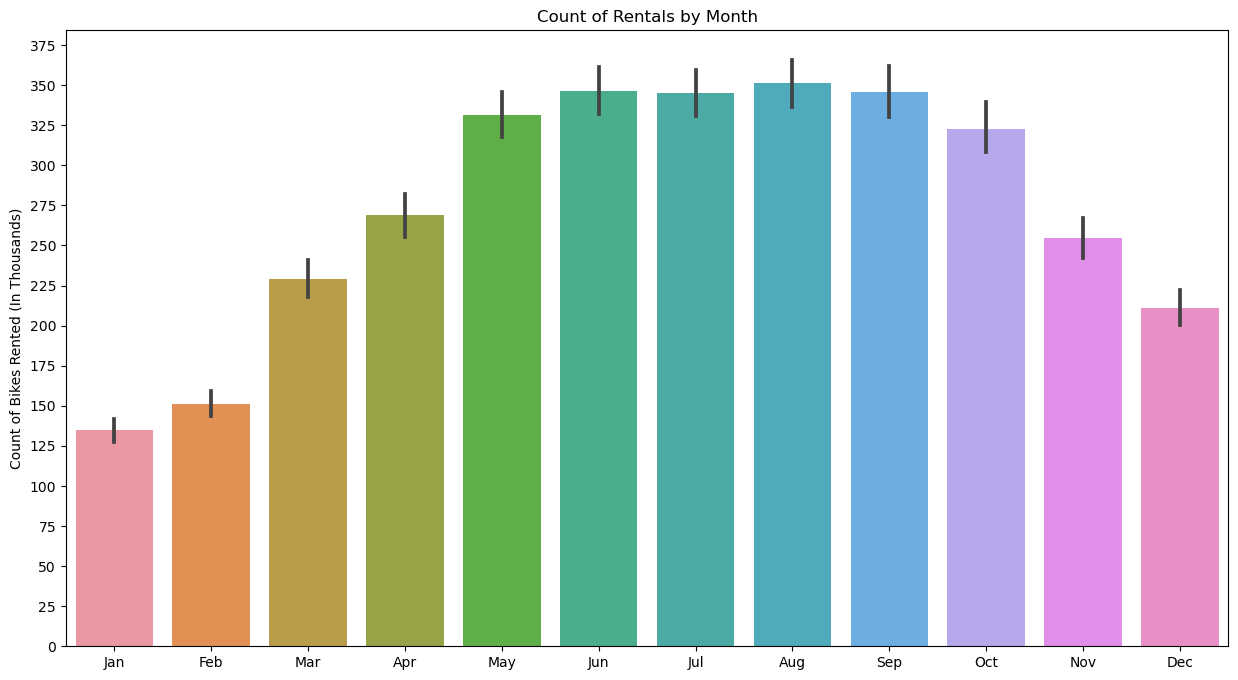

In [12]:
f3, ax3 = plt.subplots(figsize= (15, 8))
sns.barplot(data = bike_df, x='mnth', y='cnt', estimator=lambda x: x.sum()/1000, ax=ax3)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks(range(0, 376, 25))
plt.ylabel('Count of Bikes Rented (In Thousands)')
plt.xlabel(None)
plt.title('Count of Rentals by Month')
plt.show()

### Weather Situation vs Count

Unsurprisingly, as weather conditions get worse, bike rentals decline. Category 4, representing the most severe weather, having the lowest number of bike rentals with only 223 total.

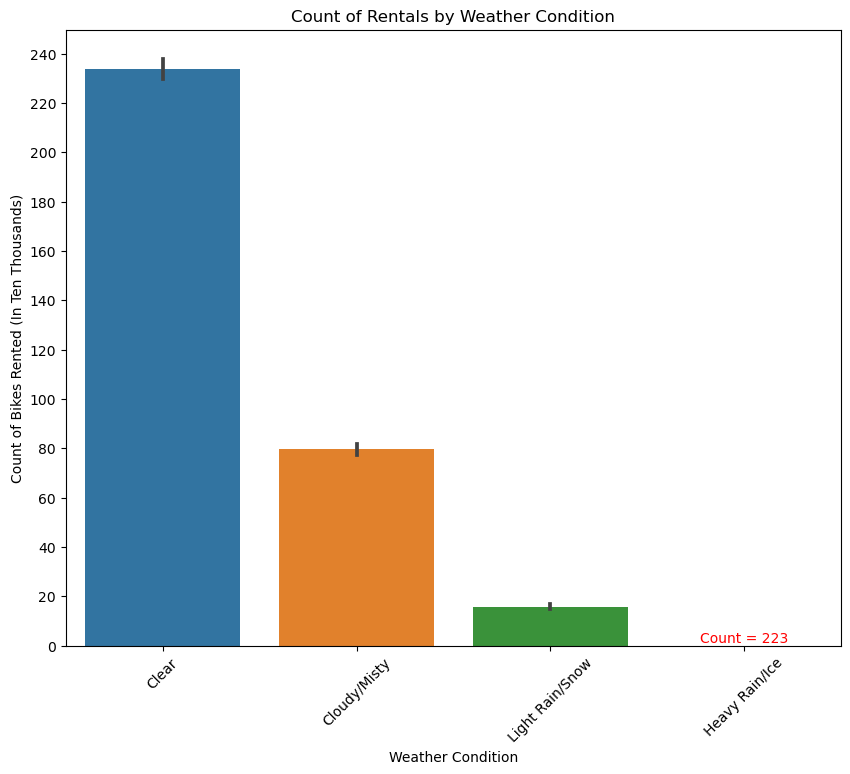

In [13]:
f4, ax4 = plt.subplots(figsize= (10, 8))
sns.barplot(data = bike_df, x='weathersit', y='cnt', estimator=lambda x: x.sum()/10000, ax=ax4)
plt.xticks([0, 1, 2, 3], ['Clear', 'Cloudy/Misty', 'Light Rain/Snow', 'Heavy Rain/Ice'], rotation = 45)
plt.yticks(range(0, 250, 20))
plt.ylabel('Count of Bikes Rented (In Ten Thousands)')
plt.xlabel('Weather Condition')
plt.title('Count of Rentals by Weather Condition')

# Because the count for category 4 is so small, it doesn't show up on the bar plot unless I make it massive. Instead, I'm adding a text label to show the count
count = bike_df['cnt'][bike_df['weathersit'] == 4].sum()
bar = ax4.patches[3]
x_coord = bar.get_x() + bar.get_width()/2
y_coord = bar.get_height()
plt.annotate(f'Count = {count}', (x_coord, y_coord), ha = 'center', va = 'bottom', color = 'red')


plt.show()

### Weather Situation vs Count (point plot)

Looking at the average number of bike rentals a few things jump out. First is that the severe weather category only sees bike rentals in winter, which makes sense since you would be more likely to experience severe weather in the winter. 

It also appears that there's a steeper drop off of bike rentals between category 2 and 3 in the fall than in other seasons. By this I mean that it seems in the Summer and Spring, a change in weather from category 1 to 2 to 3 seems to have a pretty standard impact with the average number of bike rentals decreasing about the same amount with each category change. However in the fall, the average bike rentals from 1 to 2 seems to not change much, but when it moves from 2 to 3 there's a big drop.

Two possible explanations are that because individuals are expecting nice weather in the spring and summer, any change to the worse dampens their interest in renting bike more significantly than in the fall where they expecting weather to not be as nice or that the 3rd category is much more likley to be snow in the fall and rain in the spring/summer and individuals are more likley to ride in the rain than the snow. 

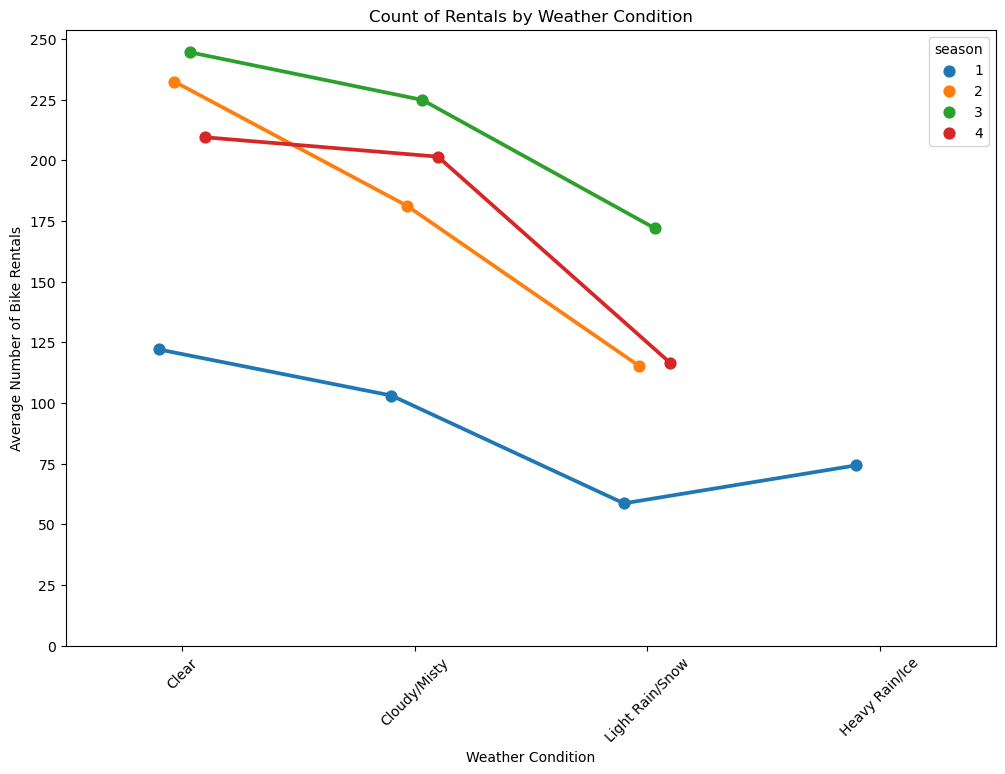

In [14]:
f5, ax5 = plt.subplots(figsize=(12, 8))
sns.pointplot(data = bike_df, x='weathersit', y='cnt', hue='season', dodge=0.2,  ax=ax5, errorbar=None)
plt.xticks([0, 1, 2, 3], ['Clear', 'Cloudy/Misty', 'Light Rain/Snow', 'Heavy Rain/Ice'], rotation = 45)
plt.yticks(range(0, 251, 25))
plt.ylabel('Average Number of Bike Rentals')
plt.xlabel('Weather Condition')
plt.title('Count of Rentals by Weather Condition')
plt.show()

### Hour vs Count

The busiest times of day appear to be around 8am and 4pm to 5pm. This matches up with the earlier assumption that we saw mroe rentals on working days because they were being used to commute.

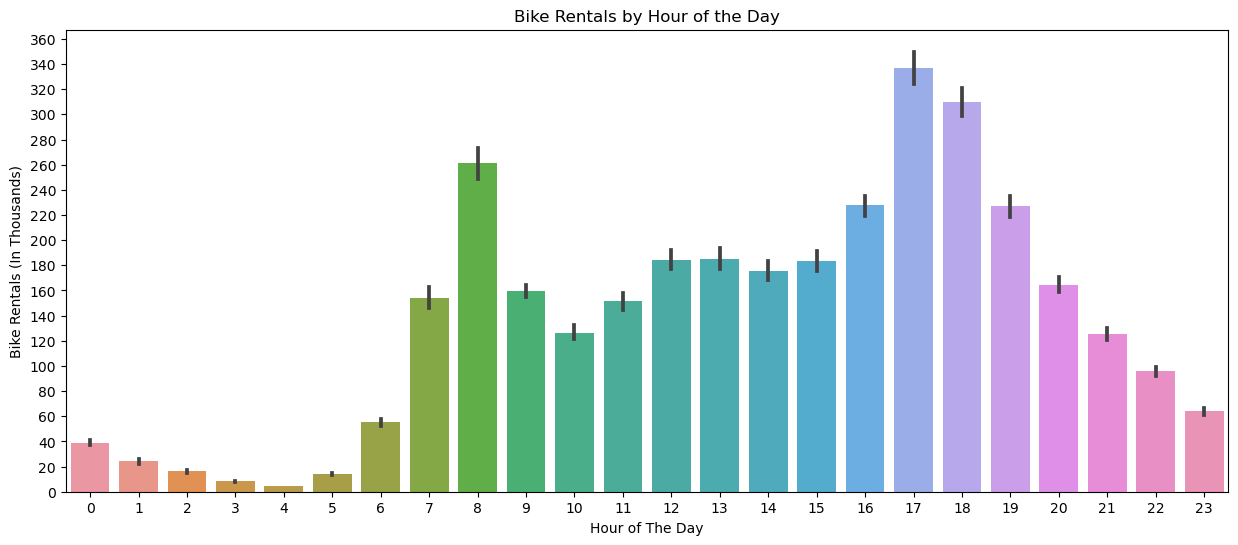

In [15]:
f6, ax6 = plt.subplots(figsize = (15, 6))
sns.barplot(data=bike_df, x='hr', y='cnt', ax=ax6, estimator= lambda x: x.sum()/1000)
plt.yticks(range(0 , 361, 20))
plt.ylabel('Bike Rentals (In Thousands)')
plt.xlabel('Hour of The Day')
plt.title('Bike Rentals by Hour of the Day')
plt.show()

### Hour vs Count, by Working Day

Looking at weekend/holiday bike rentals against working days adds more weight to the assumption. On weekends/holidays bike rentals tend to be steadier throughout the day with rentals increasing slowly after 7am, holding fairly steady until they begin to taper off again around 4pm. The spike in rentals seen in the previous plot seems to be driven, as expected, entirely by working day commuter traffic.

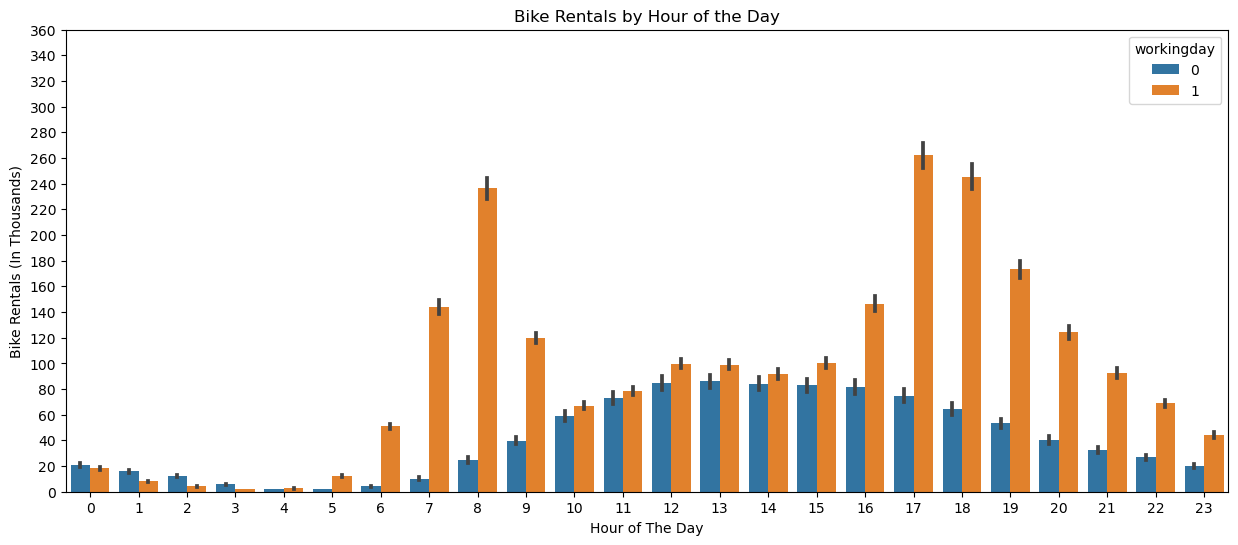

In [16]:
f7, ax7 = plt.subplots(figsize = (15, 6))
sns.barplot(data=bike_df, x='hr', y='cnt', hue='workingday', ax=ax7, estimator= lambda x: x.sum()/1000)
plt.yticks(range(0 , 361, 20))
plt.ylabel('Bike Rentals (In Thousands)')
plt.xlabel('Hour of The Day')
plt.title('Bike Rentals by Hour of the Day')
plt.show()

# Part 2 - Data Preparation

## Correlation Matrix

While not surprising, it is interesting that humidity seems to have a somewhat significant impact on the number of people renting bikes and seems to have a relationship with the hour of the day and the windspeed as well. 

It's also interesting to note that the temperature and humidity seem to have slightly more correlation for casual riders than registered riders.

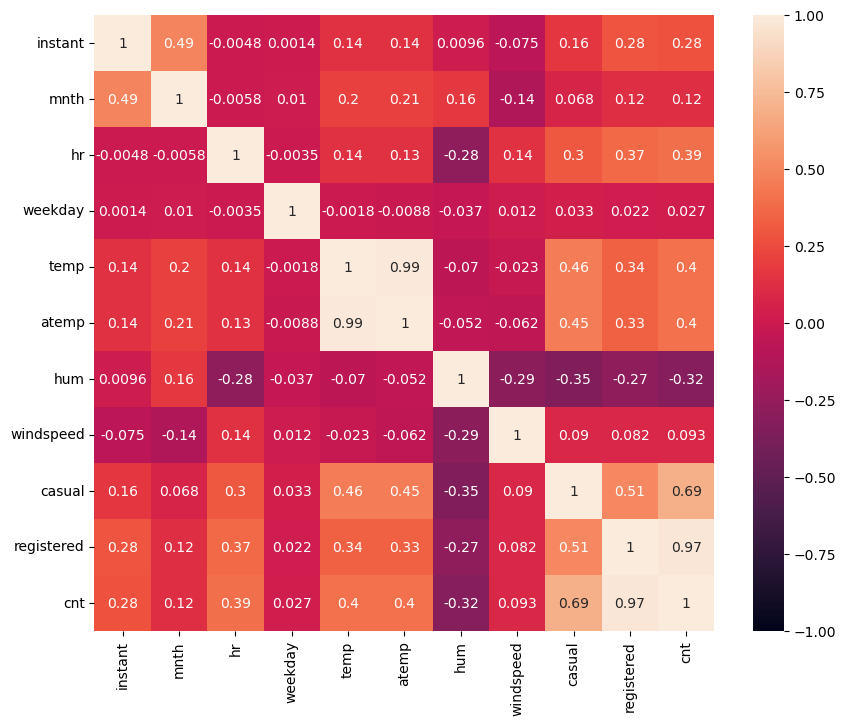

In [17]:
corr_mat = bike_df.corr(numeric_only=True)

f8, ax8 = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_mat, ax=ax8, annot=True, vmin= -1)

plt.show()

## Scale features

In [18]:
# Scaling the numberical features in the datasets
scaler = StandardScaler()

for col in bike_df.select_dtypes(include=np.number):
    scaled = scaler.fit_transform(bike_df[[col]])
    bike_df[col] = scaled

bike_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,-1.731951,2011-01-01,1,0,-1.610438,-1.670004,0,1.493891,0,1,-1.334648,-1.093281,0.947372,-1.553889,-0.662755,-0.930189,-0.956339
1,-1.731752,2011-01-01,1,0,-1.610438,-1.525374,0,1.493891,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.561343,-0.804655,-0.824022
2,-1.731552,2011-01-01,1,0,-1.610438,-1.380744,0,1.493891,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.622190,-0.837690,-0.868128
3,-1.731353,2011-01-01,1,0,-1.610438,-1.236115,0,1.493891,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.662755,-0.950010,-0.972879
4,-1.731154,2011-01-01,1,0,-1.610438,-1.091485,0,1.493891,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.723603,-1.009474,-1.039037


In [19]:
for col in bike_df_ord.select_dtypes(include=np.number):
    scaled = scaler.fit_transform(bike_df_ord[[col]])
    bike_df_ord[col] = scaled

bike_df_ord.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,-1.731951,2011-01-01,1,0,1,0,0,6,0,1,-1.334648,-1.093281,0.947372,-1.553889,-0.662755,-0.930189,-0.956339
1,-1.731752,2011-01-01,1,0,1,1,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.561343,-0.804655,-0.824022
2,-1.731552,2011-01-01,1,0,1,2,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.622190,-0.837690,-0.868128
3,-1.731353,2011-01-01,1,0,1,3,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.662755,-0.950010,-0.972879
4,-1.731154,2011-01-01,1,0,1,4,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.723603,-1.009474,-1.039037


## Drop columns

In [20]:
bike_df.drop(columns=['casual', 'registered', 'dteday', 'instant'], inplace=True)

bike_df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,-1.610438,-1.670004,0,1.493891,0,1,-1.334648,-1.093281,0.947372,-1.553889,-0.956339
1,1,0,-1.610438,-1.525374,0,1.493891,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.824022
2,1,0,-1.610438,-1.380744,0,1.493891,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.868128
3,1,0,-1.610438,-1.236115,0,1.493891,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.972879
4,1,0,-1.610438,-1.091485,0,1.493891,0,1,-1.334648,-1.093281,0.636370,-1.553889,-1.039037


In [21]:
bike_df_ord.drop(columns=['casual', 'registered', 'dteday', 'instant'], inplace=True)

bike_df_ord.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,-1.334648,-1.093281,0.947372,-1.553889,-0.956339
1,1,0,1,1,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.824022
2,1,0,1,2,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.868128
3,1,0,1,3,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.972879
4,1,0,1,4,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,-1.039037


## Histogram of Count

The majority of observations appear to be within a fairly narrow range just below the average. The observations above the average are spread over a much wider range with some very high outlier counts.

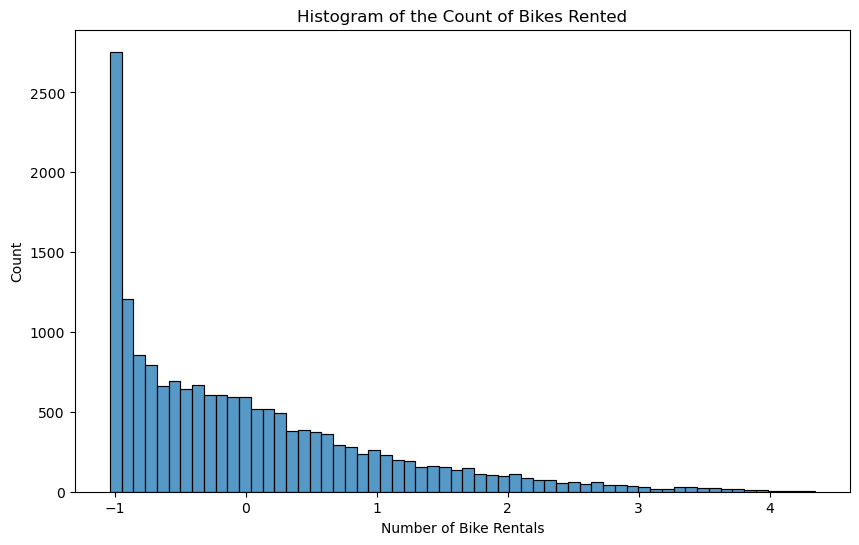

In [22]:
f9, ax9 = plt.subplots(figsize=(10, 6))
sns.histplot(data=bike_df['cnt'], bins=60)
plt.xlabel('Number of Bike Rentals')
plt.title('Histogram of the Count of Bikes Rented')

plt.show()

## Create and Score Linear Regression Model

In [23]:
# To make it easier to test the various datasets, creating a function to create and score the linear regression model
def lr_model(df):
    '''Function to test Linear Regression Model on various permutations of the bike sharing dataset'''
    features = df.drop(columns='cnt')
    target = df['cnt']

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=rs)

    lrm = LinearRegression()
    lrm.fit(X_train, y_train)

    r2 = cross_val_score(estimator=lrm, X=X_train, y=y_train, cv=10)
    neg_mse = cross_val_score(estimator=lrm, X=X_train, y=y_train, cv=10, scoring='neg_mean_squared_error')

    mse = abs(neg_mse)
    rmse = np.sqrt(abs(neg_mse))

    print(f'Average CV Scores:\n\nr2: {r2.mean()}\nmse: {mse.mean()}\nrmse: {rmse.mean()}')

    cv_scores = cv_scores2 = pd.DataFrame({'r2': r2, 'mse': mse ,'RMSE': rmse})

    return lrm, X_train, X_test, y_train, y_test, cv_scores

Treating the ordinal varaibles as categorical/numerical does not impact the model either way for theses tests. Will test again after encoding.

In [24]:
# Ordinal features treated as numerical, no encoding
lrm, X_train, X_test, y_train, y_test, cv_scores = lr_model(bike_df)

print('\nCV Scores for this model are:')
cv_scores

Average CV Scores:

r2: 0.3897895261428782
mse: 0.61086977089111
rmse: 0.7814327098591823

CV Scores for this model are:


,r2,mse,RMSE
0,0.400743,0.621411,0.788296
1,0.376506,0.604294,0.777364
2,0.375569,0.645518,0.803441
3,0.383755,0.631436,0.794629
4,0.400469,0.599484,0.774264
5,0.382263,0.605107,0.777886
6,0.418418,0.642902,0.801812
7,0.395513,0.595974,0.771993
8,0.385504,0.562433,0.749955
9,0.379154,0.600139,0.774686


In [25]:
# Ordinal features treated as categorical, no encoding
lrm, X_train, X_test, y_train, y_test, cv_scores = lr_model(bike_df_ord)

print('\nCV Scores for this model are:')
cv_scores

Average CV Scores:

r2: 0.38978952614287826
mse: 0.6108697708911099
rmse: 0.7814327098591823

CV Scores for this model are:


,r2,mse,RMSE
0,0.400743,0.621411,0.788296
1,0.376506,0.604294,0.777364
2,0.375569,0.645518,0.803441
3,0.383755,0.631436,0.794629
4,0.400469,0.599484,0.774264
5,0.382263,0.605107,0.777886
6,0.418418,0.642902,0.801812
7,0.395513,0.595974,0.771993
8,0.385504,0.562433,0.749955
9,0.379154,0.600139,0.774686


# Part 3 - Model Training

## Encoded Features Linear Model

In [26]:
# With Ordianl as Numerical
col_names = list(bike_df.select_dtypes('category').columns)
bike_df_enc = pd.get_dummies(bike_df, columns=col_names)

bike_df_enc.head(5)

,mnth,hr,weekday,temp,atemp,hum,windspeed,cnt,season_1,season_2,...,yr_0,yr_1,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,-1.610438,-1.670004,1.493891,-1.334648,-1.093281,0.947372,-1.553889,-0.956339,1,0,...,1,0,1,0,1,0,1,0,0,0
1,-1.610438,-1.525374,1.493891,-1.438516,-1.181732,0.895539,-1.553889,-0.824022,1,0,...,1,0,1,0,1,0,1,0,0,0
2,-1.610438,-1.380744,1.493891,-1.438516,-1.181732,0.895539,-1.553889,-0.868128,1,0,...,1,0,1,0,1,0,1,0,0,0
3,-1.610438,-1.236115,1.493891,-1.334648,-1.093281,0.636370,-1.553889,-0.972879,1,0,...,1,0,1,0,1,0,1,0,0,0
4,-1.610438,-1.091485,1.493891,-1.334648,-1.093281,0.636370,-1.553889,-1.039037,1,0,...,1,0,1,0,1,0,1,0,0,0


In [27]:
# With Ordinal as Categorical
col_names = list(bike_df_ord.select_dtypes('category').columns)
bike_df_enc_ord = pd.get_dummies(bike_df_ord, columns=col_names)

bike_df_enc_ord.head(5)

,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,-1.334648,-1.093281,0.947372,-1.553889,-0.956339,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
1,-1.438516,-1.181732,0.895539,-1.553889,-0.824022,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
2,-1.438516,-1.181732,0.895539,-1.553889,-0.868128,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
3,-1.334648,-1.093281,0.636370,-1.553889,-0.972879,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
4,-1.334648,-1.093281,0.636370,-1.553889,-1.039037,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0


Encoding the inital 5 categorical varaibles improves the model slightly, but not by much.

In [28]:
lrm, X_train, X_test, y_train, y_test, cv_scores = lr_model(bike_df_enc)

print('\nCV Scores for this model are:')
cv_scores

Average CV Scores:

r2: 0.3990968209506104
mse: 0.6015459246205638
rmse: 0.77543612637393

CV Scores for this model are:


,r2,mse,RMSE
0,0.407755,0.614140,0.783671
1,0.389114,0.592075,0.769464
2,0.385663,0.635083,0.796921
3,0.382832,0.632382,0.795224
4,0.406923,0.593032,0.770086
5,0.386418,0.601037,0.775266
6,0.432321,0.627533,0.792170
7,0.406978,0.584671,0.764638
8,0.391314,0.557115,0.746402
9,0.401651,0.578392,0.760521


Encoding the ordinal varaibles as well improves the model significantly. Because this dataset performs the best, we will use it moving forward for the other models. 

In [29]:
lrm, X_train, X_test, y_train, y_test, cv_scores = lr_model(bike_df_enc_ord)

print('\nCV Scores for this model are:')
cv_scores

Average CV Scores:

r2: 0.6803523332636315
mse: 0.3201031152795979
rmse: 0.5656090407481329

CV Scores for this model are:


,r2,mse,RMSE
0,0.682251,0.329496,0.574017
1,0.681740,0.308460,0.555392
2,0.674437,0.336557,0.580136
3,0.682021,0.325817,0.570804
4,0.680059,0.319916,0.565611
5,0.672679,0.320629,0.566241
6,0.695119,0.337026,0.580539
7,0.672895,0.322499,0.567890
8,0.692862,0.281116,0.530204
9,0.669461,0.319515,0.565256


In [30]:
# Renaming dataset for ease of coding

bike_df = bike_df_enc_ord

## Train Additional Models

In [31]:
# Instantiate all models
tree = DecisionTreeRegressor(random_state=0)
forest = RandomForestRegressor(random_state=0, n_estimators=30)
sgd = SGDRegressor(max_iter=1000, tol=1e-3)
lasso = Lasso(alpha=0.1)
net = ElasticNet(random_state=0)
ridge = Ridge(alpha=0.5)
bag = BaggingRegressor()

models = [tree, forest, sgd, lasso, net, ridge, bag]

In [32]:
#Iterate over each model to fit, score, and record results
scores = PrettyTable(['Model', 'r2', 'mse', 'rmse'])
for model in models:
    model.fit(X_train, y_train)
    cv_r2 = cross_val_score(estimator=model, X=X_train, y= y_train, cv=10)
    cv_mse = cross_val_score(estimator=model, X=X_train, y= y_train, cv=10, scoring='neg_mean_squared_error')
    r2 = cv_r2.mean()
    mse = abs(cv_mse).mean()
    rmse = np.sqrt(abs(cv_mse)).mean()
    scores.add_row([str(model), r2, mse, rmse])


In [33]:
# Look at scores of each model and sort by lowest RMSE

print(scores.get_string(sortby='rmse'))

+--------------------------------------------------------+------------------------+---------------------+--------------------+
|                         Model                          |           r2           |         mse         |        rmse        |
+--------------------------------------------------------+------------------------+---------------------+--------------------+
| RandomForestRegressor(n_estimators=30, random_state=0) |   0.9113902112681223   | 0.08866092953582093 | 0.2972734561742449 |
|                   BaggingRegressor()                   |   0.8990522545711643   | 0.09746534545123858 | 0.3116165941728988 |
|         DecisionTreeRegressor(random_state=0)          |   0.8261985440378753   | 0.17382351596200413 | 0.4165756487021925 |
|                    Ridge(alpha=0.5)                    |   0.6805598758357366   |  0.3198748159287873 | 0.5654143995202758 |
|                     SGDRegressor()                     |   0.6783974793121447   |  0.3216812136583594 | 0.567

# Part 4 - Model Tuning

## Best Performing Models

Based on the cross_validated scores from the previous section, my 3 best modesl are the RandomForestRegressor, BaggingRegressor, and DecisionTreeRegressor. Of those three the RandomForestRegressor outperformed the others with a RMSE of ~.297

## Randomized Search CV

In [34]:
# Note: pickle file of final model included in zip file.

# Following the guidance in the homework, njobs will be set to # of cores - 1, please update 'cores' for whatever machine you are running this on
cores = 14

# Note, 'auto' is no longer an option for the max_features parameter. Default has been changed to 1.0
# Which appears to be the same as 'auto' (i.e. use all features) so I have used that here instead
params = {
    'bootstrap': [True, False],
    'max_depth': [i for i in range(10, 111, 10)],
    'max_features': [1.0, 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [i for i in range(200, 2001, 200)]
}

search_cv = RandomizedSearchCV(estimator=forest, param_distributions=params, scoring='neg_mean_squared_error', n_jobs=cores-1, verbose=1, cv= 3, n_iter=20, random_state=rs, error_score='raise')

search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestRegressor(n_estimators=30,
                                                   random_state=0),
                   n_iter=20, n_jobs=13,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': [1.0, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=7284, scoring='neg_mean_squared_error',
                   verbose=1)

In [35]:
# Save model to avoid rerunning the previous code. 
pickle.dump(search_cv, open('hw4_searchCVmodel.sav', 'wb'))

In [36]:
# Load model if needed
forest_model = pickle.load(open('hw4_searchCVmodel.sav', 'rb'))

In [37]:
forest_model.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 1.0,
 'max_depth': 70,
 'bootstrap': True}

## Cross Validation

In [38]:
crs_val = cross_val_score(estimator=forest_model.best_estimator_, X=X_train, y=y_train, cv=5)
crs_val_mse = cross_val_score(estimator=forest_model.best_estimator_, X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')

mse = abs(crs_val_mse).mean()
rmse = np.sqrt(abs(crs_val_mse)).mean()

print(f'r2: {crs_val.mean()}\nmse: {mse}\nrmse: {rmse}')


r2: 0.9033663164348642
mse: 0.09687869042668232
rmse: 0.3109234978027826


## Evaluate on Test Data

In [39]:
preds = forest_model.best_estimator_.predict(X_test)

r2 = r2_score(y_pred=preds, y_true=y_test)
mse = mean_squared_error(y_pred=preds, y_true=y_test)
rmse = np.sqrt(mse)

print(f'The scores for the final model are:\nr2: {r2}\nMSE: {mse}\nRMSE: {rmse}')

The scores for the final model are:
r2: 0.9183046884906015
MSE: 0.08132980854613583
RMSE: 0.2851838153649955
